### 데이터 수집 및 전처리

In [94]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

train_df=pd.read_csv('C:/jupyter/kdigital_lecture/우준식 강사님 수업/train.csv',nrows=2000)

unused_columns=['id','hour','device_id','device_ip']
label_columns='click'

train_df=train_df.drop(unused_columns,axis=1)

x_dict_train=list(train_df.drop(label_columns,axis=1).T.to_dict().values())   #T=trainsfer 행과 열이 바뀜 
y_train=train_df[label_columns]

test_df=pd.read_csv('C:/jupyter/kdigital_lecture/우준식 강사님 수업/train.csv',header=0,skiprows=(1,2000),nrows=2000)
test_df=test_df.drop(unused_columns,axis=1)

x_dict_test=list(test_df.drop(label_columns,axis=1).T.to_dict().values())
y_test=test_df[label_columns]

vectorizer=DictVectorizer(sparse=True)   #희소행렬만듦
x_train=vectorizer.fit_transform(x_dict_train)   #
x_test=vectorizer.transform(x_dict_test)

In [92]:
x_train

<2000x992 sparse matrix of type '<class 'numpy.float64'>'
	with 38000 stored elements in Compressed Sparse Row format>

In [93]:
x_test

<2000x992 sparse matrix of type '<class 'numpy.float64'>'
	with 37999 stored elements in Compressed Sparse Row format>

###  1.의사결정트리 그리기

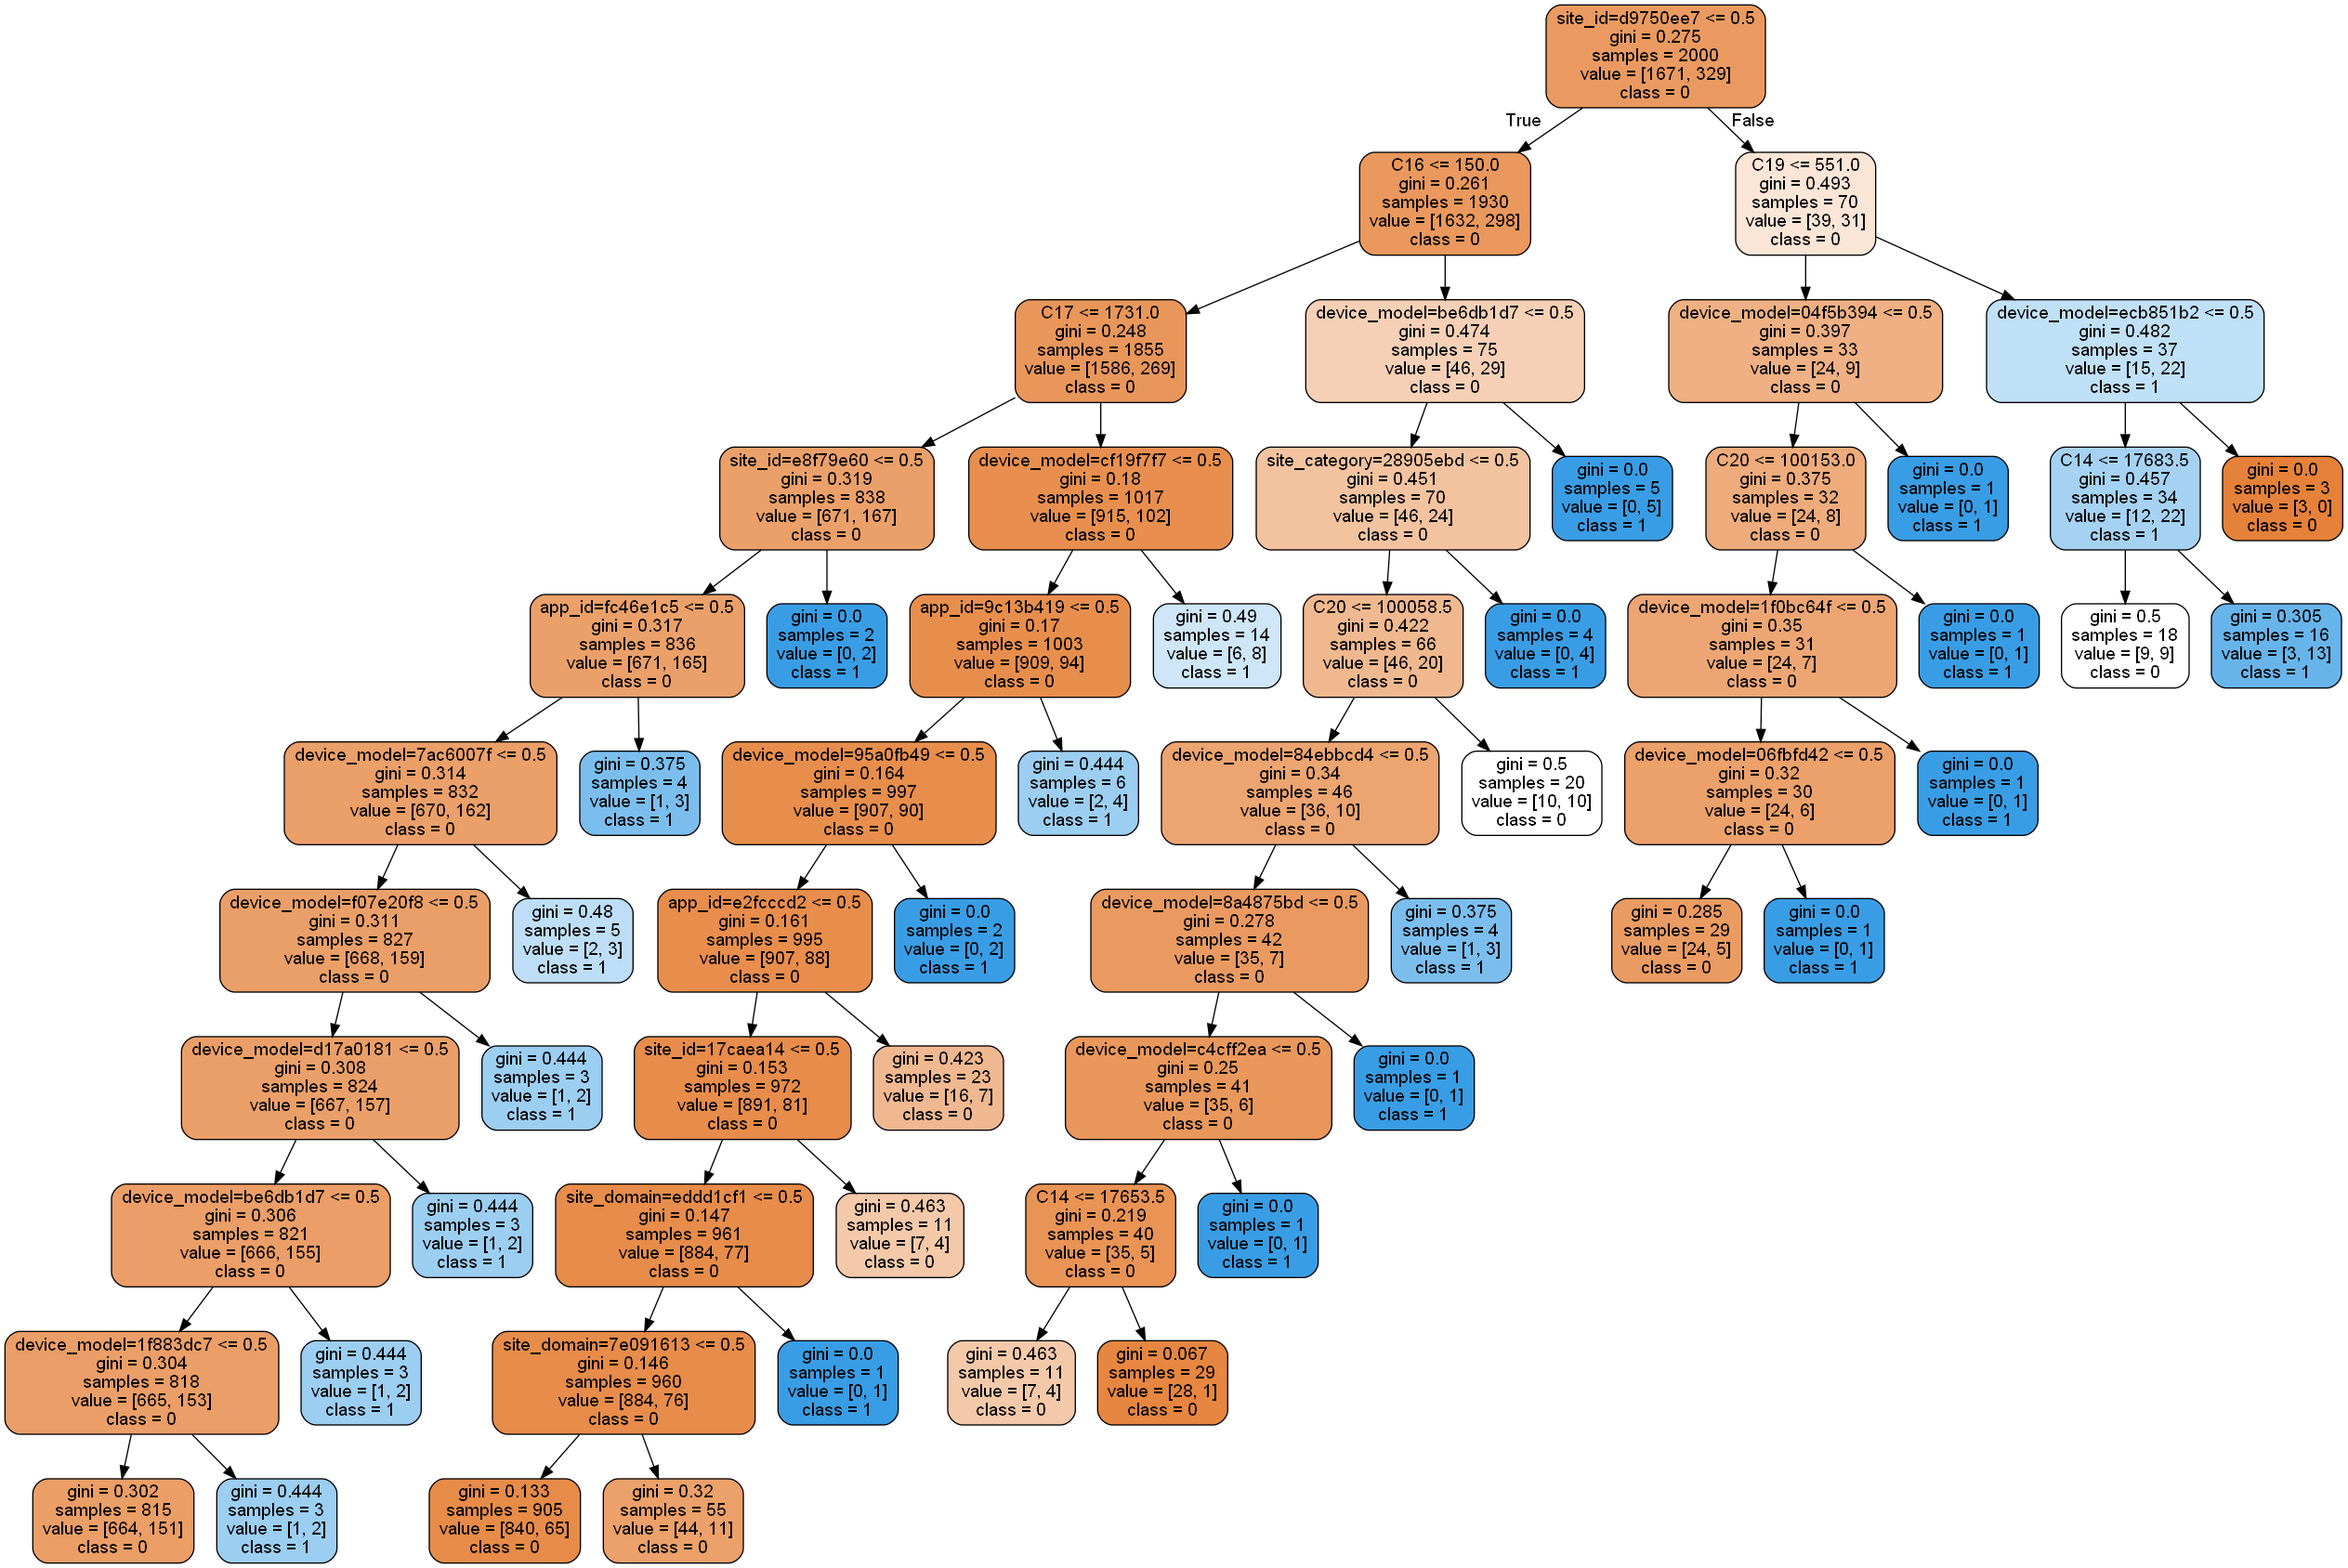

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import pydotplus
from IPython.core.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


parameters={'max_depth':[3,10,None]}   #행렬 개수 제한 
decision_tree=DecisionTreeClassifier(criterion='gini',min_samples_split=30)
grid_search=GridSearchCV(decision_tree,parameters,n_jobs=-1,cv=3,scoring='roc_auc')
grid_search.fit(x_train,y_train)
decision_tree_best=grid_search.best_estimator_

dot_data=export_graphviz(decision_tree_best,out_file=None,class_names=['0','1'],feature_names=vectorizer.feature_names_,rounded=True,impurity=True,filled=True)

y_pred=decision_tree_best.predict(x_test)

graph = pydotplus.graph_from_dot_data(dot_data)
# graph.set_size('"30,30!"')
graph.write_png("onlineAD.png")
Image("onlineAD.png")

In [60]:
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.857
[[1652   19]
 [ 267   62]]


### 2.knn으로 하기

In [95]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)

fpr2,tpr2,_=roc_curve(y_test,y_pred)
auc2=roc_auc_score(y_test,y_pred)

grid_search=GridSearchCV(knn, {'n_neighbors':[1,2,3,4,5]},n_jobs=-1, cv=7, scoring='roc_auc')
grid_search.fit(x_train,y_train)    #scoring에 따라 정확도 달라짐 


print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.949
[[1623   47]
 [  55  275]]
0.9025948103792416


In [97]:
fpr2

array([0.        , 0.02814371, 1.        ])

### 3.랜덤포레스트로 하기

In [62]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier(n_estimators=100,criterion='gini',min_samples_split=30,n_jobs=-1)
grid_search=GridSearchCV(random_forest,parameters,n_jobs=-1,cv=3,scoring='roc_auc')
grid_search.fit(x_train,y_train)
random_forest_best=grid_search.best_estimator_
y_pred=random_forest_best.predict(x_test)


y_pred_proba=random_forest_best.predict_proba(x_test)[:,1]
fpr3,tpr3,_=roc_curve(y_test,y_pred_proba)
auc3=roc_auc_score(y_test,y_pred_proba)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.8645
[[1668    3]
 [ 268   61]]
0.5918075011050297


### 4.로지스틱회귀

In [63]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf=LogisticRegression()
clf.fit(x_train,y_train)

parameters={'C':[0.001,0.01,0.1,1,10],'penalty':['l1','l2']}
grid_search=GridSearchCV(clf,parameters,n_jobs=-1,cv=3,scoring='roc_auc')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [64]:
grid_search.best_params_

{'C': 1, 'penalty': 'l2'}

In [67]:
clf_best=grid_search.best_estimator_
y_pred=clf_best.predict(x_test)
y_pred_proba=clf_best.predict_proba(x_test)[:,1]
fpr4,tpr4,_=roc_curve(y_test,y_pred_proba)
auc4=roc_auc_score(y_test,y_pred_proba)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.834
[[1667    4]
 [ 328    1]]
0.5003228687479423


## 모든 알고리즘 roc 커브로 표현 

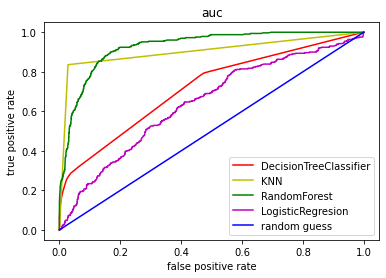

In [73]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt



plt.plot(fpr1,tpr1,'r-',label='DecisionTreeClassifier')
plt.plot(fpr2,tpr2,'y-',label='KNN')
plt.plot(fpr3,tpr3,'g-',label='RandomForest')
plt.plot(fpr4,tpr4,'m-',label='LogisticRegresion')

plt.plot([0,1],[0,1],'b-',label='random guess')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('auc')

plt.legend(loc='lower right')